# Veri Yoğun Uygulamalar (Spark) Ödevi
## Atalay Bektaş

## Konut Fiyatlarının Tahmini için Spark ile Regresyon Modeli Oluşturulması

### Amaç ve Kapsam
Tanımlanan veri seti üzerinde konut fiyatlarının tahminlenmesi için Spark ML kütüphanesi kullanılarak
PySpark ile bir regresyon modeli oluşturulacaktır.

### Veri Kümesi
Veri kümesi: California Housing Prices
https://www.kaggle.com/datasets/camnugent/california-housing-prices

spark dökümantasyoun:
https://spark.apache.org/docs/latest/ml-classification-regression.html

### Adımlar:
#####-Verilerin yüklenmesi
#####-Verilerin çeşitli Spark fonksiyonları kullanılarak incelenmesi
#####-Özniteliklerin seçimi ve verilerin makine öğrenmesi için hazırlanması,
#####-PySpark ile makine öğrenmesi modelinin oluşturulması
#####-Geliştirilen modelin performansının ölçümü

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler


### pyspark SparkSession oturumu oluşturmak

In [3]:
# Starting SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('House_Price Prediction with PySpark').getOrCreate()

### PySpark ile housing.csv datasını oku DaraFrame e dönüştür ilk 20 satırı göster

In [4]:
#Upload housing.csv data
# data to DataFrame format
df_pyspark = spark.read.option('header','true').csv('/content/drive/MyDrive/YZUP/housing.csv', inferSchema = True)
df_pyspark.show(20)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

### DataFrame satır sayısı

In [5]:
#DataFrame row Count
df_pyspark.count()

20640

###  PySpark DataFrame bilgisi istatistikleri

In [6]:
df_pyspark.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

### Eksik değerleri yazdıran döngü

In [7]:
#Her sütün için eksik değerleri sayan döngü
for colu in df_pyspark.columns:
    miss = df_pyspark.filter(col(colu).isNull()).count()
    print(f"{colu} columns {miss} has missing value.")

longitude columns 0 has missing value.
latitude columns 0 has missing value.
housing_median_age columns 0 has missing value.
total_rooms columns 0 has missing value.
total_bedrooms columns 207 has missing value.
population columns 0 has missing value.
households columns 0 has missing value.
median_income columns 0 has missing value.
median_house_value columns 0 has missing value.
ocean_proximity columns 0 has missing value.


### Eksik değerlerin doldurulması

In [8]:
# total_bedroomsda eksik veriler var
mean_bedroom = df_pyspark.select(mean(df_pyspark['total_bedrooms'])).collect()[0][0]
#Ortalama (mean_bedroom) değer ile ile eksik değerleri doldurmak
df_pyspark = df_pyspark.na.fill({'total_bedrooms': mean_bedroom})

#Eksik değer kontrolü
df_pyspark.filter(col("total_bedrooms").isNull()).count()

0

### IQR yöntemiyle uç değer hesaplayarak PySpark DataFrame'ini temizlemek

In [9]:
#Outlier temizlemek

# IQR yöntemi ile Outlier temizlemek
Q1 = df_pyspark.approxQuantile("total_rooms", [0.25], 0)[0]
Q3 = df_pyspark.approxQuantile("total_rooms", [0.75], 0)[0]
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper= Q3 + 1.5 * IQR

df_pyspark = df_pyspark.filter((col("total_rooms") >= lit(lower)) & (col("total_rooms") <= lit(upper)))
#Temizlenmiş veri satır count
df_pyspark.count()


19354

### Model eğitimi için Train-Test Split

In [10]:
#Train Test Split
splits = df_pyspark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print("Training row count:", train_rows, " Testing row count:", test_rows)

Training row count: 15536  Testing row count: 3818


### Veri Ön İşlemleri

In [11]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# ocean_promixity nin sayısal hale getirilmesi
stringIndexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_idx")
stringIndexerModel = stringIndexer.fit(train)
train_transformed = stringIndexerModel.transform(train)

# VectorAssembler
assembler = VectorAssembler(
    inputCols=["ocean_proximity_idx", "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"],
    outputCol="features"
)

# Traning Verisi
training = assembler.transform(train_transformed).select(col("features"), (col("median_house_value").cast("Int").alias("label")))
training.show()


+--------------------+------+
|            features| label|
+--------------------+------+
|[2.0,-124.3,41.8,...| 85800|
|[2.0,-124.3,41.84...|103600|
|[2.0,-124.27,40.6...| 79000|
|[2.0,-124.26,40.5...|111400|
|[2.0,-124.25,40.2...| 76100|
|[2.0,-124.23,40.5...|106700|
|[2.0,-124.23,40.8...| 50800|
|[2.0,-124.23,41.7...| 73200|
|[2.0,-124.22,41.7...| 78300|
|[2.0,-124.21,41.7...| 66900|
|[2.0,-124.21,41.7...| 68400|
|[2.0,-124.19,40.7...| 90100|
|[2.0,-124.19,40.7...| 70000|
|[2.0,-124.19,41.7...| 74600|
|[2.0,-124.18,40.6...|107000|
|[2.0,-124.18,40.7...| 72200|
|[2.0,-124.18,40.7...| 67000|
|[2.0,-124.18,40.7...| 70200|
|[2.0,-124.18,40.7...| 70500|
|[2.0,-124.18,40.7...| 64600|
+--------------------+------+
only showing top 20 rows



In [12]:
#Test verisi
test_transformed = stringIndexerModel.transform(test)

testing = assembler.transform(test_transformed).select(
    "features",
    (col("median_house_value").cast("Int").alias("trueLabel"))
)

testing.show()


+--------------------+---------+
|            features|trueLabel|
+--------------------+---------+
|[2.0,-124.35,40.5...|    94600|
|[2.0,-124.21,40.7...|    58100|
|[2.0,-124.19,40.7...|    69000|
|[2.0,-124.17,40.7...|    82800|
|[2.0,-124.17,41.7...|   105900|
|[2.0,-124.17,41.8...|   109400|
|[2.0,-124.16,40.7...|    76900|
|[2.0,-124.16,40.8...|    74100|
|[2.0,-124.16,40.8...|    80500|
|[2.0,-124.16,40.9...|    96000|
|[2.0,-124.15,40.8...|    57500|
|[2.0,-124.14,40.5...|    66800|
|[2.0,-124.14,40.6...|   128100|
|[2.0,-124.11,40.9...|    81700|
|[2.0,-124.1,40.88...|    81100|
|[2.0,-124.1,40.95...|    78400|
|[2.0,-124.1,41.04...|    97900|
|[0.0,-124.09,40.4...|    70500|
|[0.0,-124.09,40.5...|    97300|
|[2.0,-124.09,40.8...|    75000|
+--------------------+---------+
only showing top 20 rows



### Lineer Regression

In [13]:
#Linear Regresion Model
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="label")
lrModel = lr.fit(training)
lrPredictions = lrModel.transform(testing)

# Performans Metric
evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction")
lrRmse = evaluator.evaluate(lrPredictions, {evaluator.metricName: "rmse"})
lrMae = evaluator.evaluate(lrPredictions, {evaluator.metricName: "mae"})
lrR2 = evaluator.evaluate(lrPredictions, {evaluator.metricName: "r2"})
print(f"Linear Regression - RMSE: {lrRmse}")
print(f"Linear Regression - MAE: {lrMae}")
print(f"Linear Regression - R^2: {lrR2}")

Linear Regression - RMSE: 69756.54915747672
Linear Regression - MAE: 51124.2865983693
Linear Regression - R^2: 0.6364369792568937


#### Lineer Regresyon Tahmin grafiği

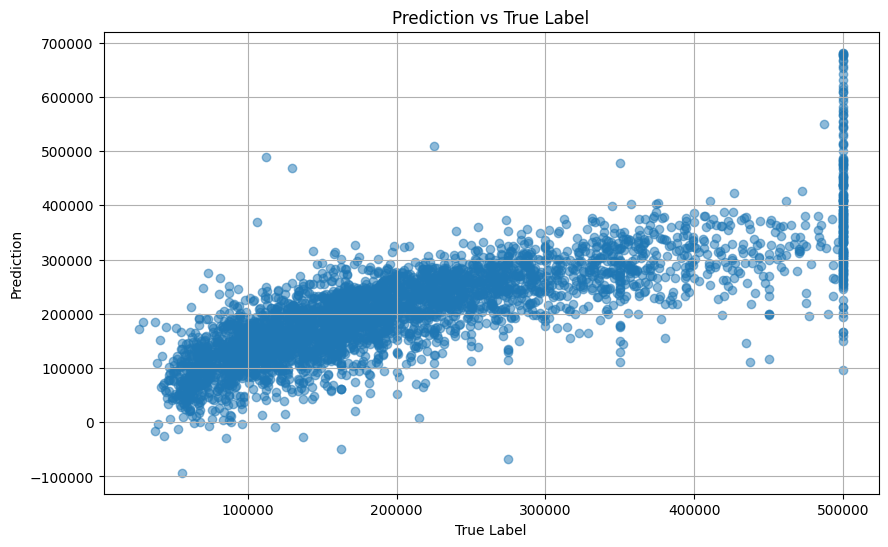

In [14]:
import matplotlib.pyplot as plt

# Pandas DataFrame
df = lrPredictions.select("prediction", "trueLabel").toPandas()
# Graph for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()

### RandomForestRegressor

In [15]:
from pyspark.ml.regression import RandomForestRegressor

#Train ve Test for Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rfModel = rf.fit(training)
rfPredictions = rfModel.transform(testing)

#RMSE MAE R'2
rfRmse = evaluator.evaluate(rfPredictions, {evaluator.metricName: "rmse"})
rfMae = evaluator.evaluate(rfPredictions, {evaluator.metricName: "mae"})
rfR2 = evaluator.evaluate(rfPredictions, {evaluator.metricName: "r2"})
print(f"RandomForestRegressor - RMSE: {rfRmse}")
print(f"RandomForestRegressor - MAE: {rfMae}")
print(f"RandomForestRegressor - R^2: {rfR2}")

RandomForestRegressor - RMSE: 69066.25755758476
RandomForestRegressor - MAE: 50949.52488285817
RandomForestRegressor - R^2: 0.643596816275247


### RandomForest tahmin grafiği

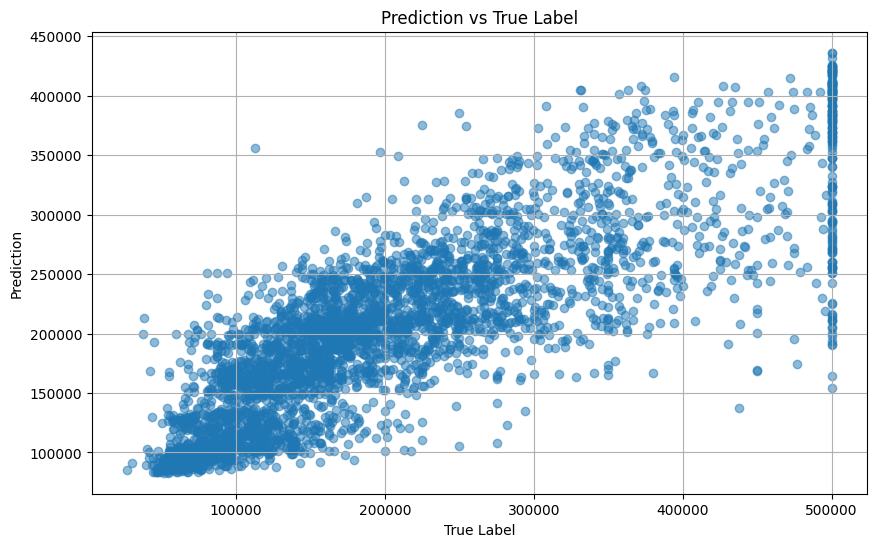

In [16]:
# Pandas DataFrame
df = rfPredictions.select("prediction", "trueLabel").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()


### GradiantBoosting

In [17]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100)
gbtModel = gbt.fit(training)
gbtPredictions = gbtModel.transform(testing)
gbtPredicted = gbtPredictions.select("features", "prediction", "trueLabel")

evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction")

gbtRmse = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "rmse"})
gbtMae = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "mae"})
gbtR2 = evaluator.evaluate(gbtPredictions, {evaluator.metricName: "r2"})
print(f"GradiantBoosting - RMSE: {gbtRmse}")
print(f"GradiantBoosting - MAE: {gbtMae}")
print(f"GradiantBoosting - R^2: {gbtR2}")


GradiantBoosting - RMSE: 50565.52349461436
GradiantBoosting - MAE: 34302.38542805882
GradiantBoosting - R^2: 0.8089624487042226


### GradiantBoosting tahmin grafiği

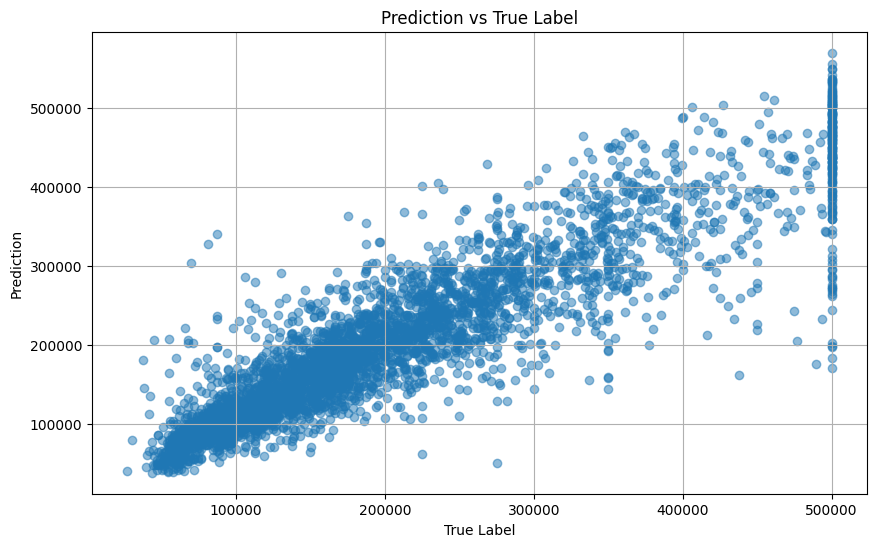

In [18]:
# Pandas DataFrame
df = gbtPredictions.select("prediction", "trueLabel").toPandas()
# Graph
plt.figure(figsize=(10, 6))
plt.scatter(df['trueLabel'], df['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs True Label')
plt.grid(True)
plt.show()